# IRCS polarimetry reduction pipeline

* IRCS K-band PDI engineering data was kindly provided by Kudo-san on 2017/04/10
* check obslog e.g. CYG OB2 3 in [SMOKA](http://smoka.nao.ac.jp/search?resolver=NONE&object=CYG%20OB2%203&instruments=IRC&spectrographs=IRC&obs_mod=all&data_typ=OBJECT&dispcol=default&action=Search&diff=1000&asciitable=Table)


* object: BD323739 (as unpolarized standard star)
* object: Cyg OB2 #3 (as polarized standard star)

* IRCA00428737-756: half waveplate 4 position sets (1set: 0-45-22.5-67.5 deg)
* flat image using Cal source at NsIR
 * IRCA00428919-930:  Flat ON,   wp pos 0 deg.
 * IRCA00428931-942:  Flat ON,   wp pos 45 deg.
 * IRCA00428943-954:  Flat ON,   wp pos 22.5 deg.
 * IRCA00428955-966:  Flat ON,   wp pos 67.5 deg.
 * IRCA00428967-978:  Flat OFF,  wp pos 0 deg.
 * IRCA00428979-990:  Flat OFF,  wp pos 45 deg.
 * IRCA00428991-9002: Flat OFF,  wp pos 22.5 deg.
 * IRCA00429003-014:  Flat OFF,  wp pos 67.5 deg.

Vizier/simbad: (unavailable) but see [BD+32 3739, HD 331891](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=HD+331891)

* J 8.800
* H 8.775
* K 8.721 

## Data Reduction Pipeline

* inspecting raw data
* making dark frame
* making cal-flat frame
* masking bad pixels
* making sky-flat frame
* subtracting flat-field
* subtracting sky frame
* interpolating for bad pixel
* measuring position offset
* shifting and combining images (image registration)
* analyzing standard star
* estimating limiting magnitude

## Check header

In [137]:
import numpy as np
try:
    from astropy.io import fits as pf
except:
    import pyfits as pf
from glob import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm

In [138]:
filedir = '/mnt/B838B30438B2C124/data/ircs_pol'
file_list = glob(os.path.join(filedir,'*.fits'))
file_list.sort()

len(file_list)

136

In [140]:
obj=[]
for i in tqdm(file_list):
    hdr=pf.open(i)[0].header
    obj.append(hdr['OBJECT'])
set(obj)

100%|██████████| 136/136 [00:01<00:00, 113.34it/s]


{'BD+32 3739',
 'Cyg OB2 No.3',
 'IMAGE_Kp_OFF HWP0',
 'IMAGE_Kp_OFF HWP22.5',
 'IMAGE_Kp_OFF HWP45',
 'IMAGE_Kp_OFF HWP67.5',
 'IMAGE_Kp_ON HWP0',
 'IMAGE_Kp_ON HWP22.5',
 'IMAGE_Kp_ON HWP45',
 'IMAGE_Kp_ON HWP67.5'}

In [5]:
pol = [] #Cyg, polarized
unpol = [] #BD32, unpol
off = []
on = []

for i in tqdm(file_list):
    hdr=pf.open(i)[0].header
    if hdr['OBJECT'] == 'BD+32 3739':
        unpol.append(i)
    elif hdr['OBJECT'] == 'Cyg OB2 No.3':
        pol.append(i)
    elif hdr['OBJECT'].split()[0].split('_')[2] == 'OFF':
        #'IMAGE_Kp_OFF HWP0'
        #'IMAGE_Kp_OFF HWP22.5'
        #'IMAGE_Kp_OFF HWP45'
        #'IMAGE_Kp_OFF HWP67.5'
        off.append(i)
        
    else:
        #'IMAGE_Kp_ON HWP0',
        #'IMAGE_Kp_ON HWP22.5',
        #'IMAGE_Kp_ON HWP45',
        #'IMAGE_Kp_ON HWP67.5
        on.append(i)

100%|██████████| 136/136 [00:01<00:00, 108.95it/s]


In [12]:
print('polarized={0} frames\nunpolarized standard={1}\non={2}\noff={3}'.
      format(len(pol),len(unpol),len(on),len(off)))

polarized=20 frames
unpolarized standard=20
on=48
off=48


In [13]:
#other parameters of interest
params = 'OBS-MOD, EXP1TIME, COADD, EXPTIME, SLIT, RA, DEC, D_MODE, I_SCALE, I_DTHNUM, I_DTHPOS'.split()

* obs-mode=imaging
* COADD: 20
* EXP1TIME: 0.2s, 0.12s
* EXPTIME: 4s for BD+32 3739, 2.4s for Cyg OB2 No.3
* SLIT: mirror for for BD+32 3739, Polarimetry mask for Cyg OB2 No.3
* RA: 20:12:01 & 20:31:37 for D+32 3739 & Cyg OB2 No.3
* DEC: 32:47:40 - 52 & 41:13:16 - 26 for D+32 3739 & Cyg OB2 No.3
* D_MODE: NGS
* I_SCALE: 20 mas
* I_DTHNUM: 5
* I_DTHPOS: {1-5: WP(0,45, 22.5. 67.5)}; WP = waveplate position
* FILTER01= 'OPEN:1            ' / First filter element                           
* FILTER02= 'Kp                ' / Second filter element                          
* FILTER03= 'Wollaston Prism   ' / Third filter element   

In [14]:
exptime=0.2
coadd=20
dither=5
wp_pos=4

int_time=exptime*coadd*dither*wp_pos
int_time

80.0

In [135]:
240/60

4.0

Without dither, int_time = 2.4 s. For Kp, the BLIP time is 30s. The saturation magnitude at single expsure of 1 s for Kp=11.1. Thus, 0.2 s single exposure per frame makes sense for BD239 with K=8.7.

In [15]:
#dome flat on exptime
pf.open(on[0])[0].header['EXPTIME']

0.5

In [8]:
#int time of DF on
pf.open(on[0])[0].header['EXPTIME']*len(on)

24.0

In [16]:
#int time of DF off
pf.open(off[0])[0].header['EXPTIME']*len(off)

24.0

In [6]:
pol_param = []
unpol_param = []
#obj
for i in pol:
    hdr=pf.open(i)[0].header
    pol_param.append(hdr['I_DTHPOS'])
    
#ref
for i in unpol:
    hdr=pf.open(i)[0].header
    unpol_param.append(hdr['I_DTHPOS'])

In [18]:
set(pol_param)

{'1 : WP0',
 '1 : WP22.5',
 '1 : WP45',
 '1 : WP67.5',
 '2 : WP0',
 '2 : WP22.5',
 '2 : WP45',
 '2 : WP67.5',
 '3 : WP0',
 '3 : WP22.5',
 '3 : WP45',
 '3 : WP67.5',
 '4 : WP0',
 '4 : WP22.5',
 '4 : WP45',
 '4 : WP67.5',
 '5 : WP0',
 '5 : WP22.5',
 '5 : WP45',
 '5 : WP67.5'}

In [19]:
set(unpol_param)

{'1 : WP0',
 '1 : WP22.5',
 '1 : WP45',
 '1 : WP67.5',
 '2 : WP0',
 '2 : WP22.5',
 '2 : WP45',
 '2 : WP67.5',
 '3 : WP0',
 '3 : WP22.5',
 '3 : WP45',
 '3 : WP67.5',
 '4 : WP0',
 '4 : WP22.5',
 '4 : WP45',
 '4 : WP67.5',
 '5 : WP0',
 '5 : WP22.5',
 '5 : WP45',
 '5 : WP67.5'}

## Test image

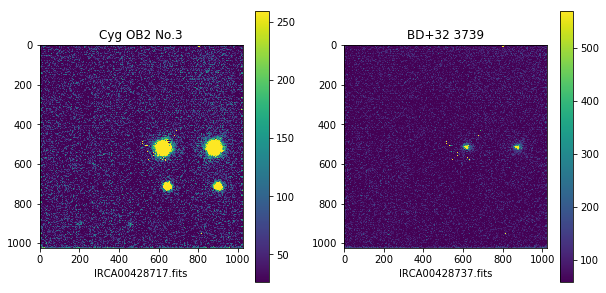

In [141]:
#Cyg
pol_image = pf.open(pol[0])[0].data
unpol_image = pf.open(unpol[0])[0].data

on_image = pf.open(on[0])[0].data
off_image = pf.open(off[0])[0].data

vmin1, vmax1 = np.median(pol_image), 10*np.median(pol_image)
vmin2, vmax2 = np.median(unpol_image), 10*np.median(unpol_image)

fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
ax1 = ax[0].imshow(pol_image,vmin=vmin1,vmax=vmax1)
ax[0].set_title(pf.open(pol[0])[0].header['OBJECT'])
ax[0].set_xlabel(pol[0].split("/")[-1])
fig.colorbar(ax1, ax=ax[0])

ax2 = ax[1].imshow(unpol_image,vmin=vmin2,vmax=vmax2)
ax[1].set_title(pf.open(unpol[0])[0].header['OBJECT'])
ax[1].set_xlabel(unpol[0].split("/")[-1])
fig.colorbar(ax2, ax=ax[1])

[Simbad](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=HD+331891) shows that the target is the brighter object and the one below is a background star. The left is the o-ray and right is e-ray.

In [15]:
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(test_image, sigma=3.0, iters=5)
print((mean, median, std))    

(25.759773311900247, 25.0, 43.229812895755259)


## Compute centroid

In [142]:
def get_crop(image, centroid, box_size):
    x, y = centroid
    image_crop = np.copy(image[int(y-(box_size/2)):int(y+(box_size/2)),int(x-(box_size/2)):int(x+(box_size/2))])

    return image_crop

## Cropping with eye-ball estimate of centroid

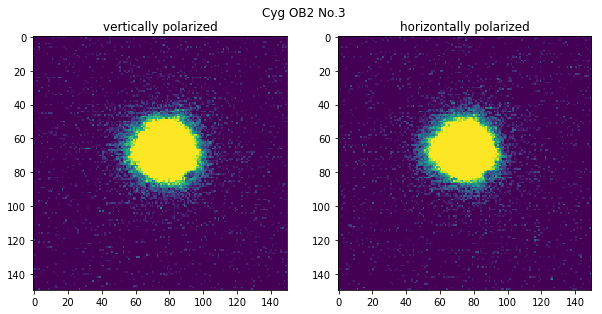

In [58]:
centroid_left = (640,720) #o-ray
centroid_right = (900,720) #e-ray
box_size = 150

image = pf.open(pol[0])[0].data
o = get_crop(image, centroid_left, box_size)
e = get_crop(image, centroid_right, box_size)

#mean, median, std = sigma_clipped_stats(test_image, sigma=3.0, iters=5)
vmin,vmax= np.median(o), 10*np.median(o)

fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(o-np.median(o), vmin=vmin, vmax=vmax)
axs[0].set_title('vertically polarized')
axs[1].imshow(e-np.median(e), vmin=vmin, vmax=vmax)
axs[1].set_title('horizontally polarized')
fig.suptitle(pf.open(pol[0])[0].header['OBJECT'])
fig.subplots_adjust(top=1.4)

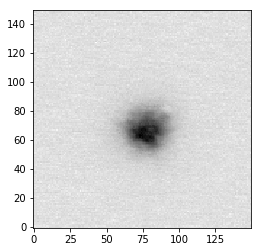

In [26]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(top1,cmap='Greys', origin='lower', norm=norm)
plt.show()

## PSF check

In [143]:
from photutils.centroids import centroid_com as com

def get_centroid(image):
    '''
    Calculate the centroid of a 2D array as its 'center of mass' determined from image moments.
    '''
    centroid = com(image)
    return centroid

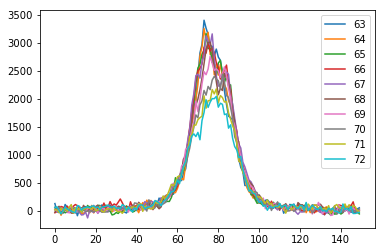

In [8]:
centroid_left = (640,720) #o-ray
centroid_right = (900,720) #e-ray
box_size = 150

image = pf.open(pol[0])[0].data
o = get_crop(image, centroid_left, box_size)
center=get_centroid(o)
swath = np.arange(int(center[1])-5,int(center[1])+5,1)
for i in swath:
    plt.plot(o[i,:],label=i)
plt.legend()

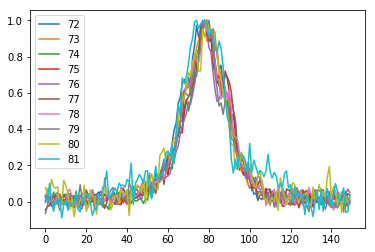

In [64]:
#normalized
swath = np.arange(int(center[0])-5,int(center[0])+5,1)
psf_swath = []
for i in swath:
    line=o[i]/np.max(o[i])
    psf_swath.append(line)
    plt.plot(line,label=i)
plt.legend()

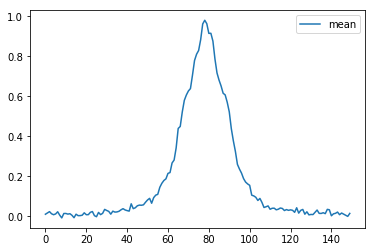

In [28]:
mean_psf_swath = np.mean(psf_swath,axis=0)
#median_psf_swath = np.median(psf_swath,axis=0)
plt.plot(mean_psf_swath,label='mean')
#plt.plot(median_psf_swath, label='median')
plt.legend()

In [12]:
#using scipy
from scipy.optimize import curve_fit

def gauss(x, *params):
    A, mu, sigma, eps= params
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + eps


A: 0.877927888742
mu: 78.3011651169
sigma= 10.333496206
eps: 0.0246716346484


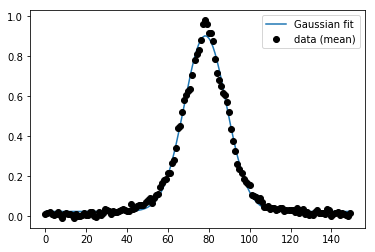

In [29]:
#estimate mean and standard deviation
ydata = np.copy(mean_psf_swath)
xdata = np.array(range(len(ydata)))
mean = center[1]
sigma = np.std(ydata)
#fitting
eps =0.1
popt, pcov = curve_fit(gauss, xdata, ydata, p0 = [1, mean, sigma, eps])

plt.plot(xdata,gauss(xdata, *popt), label='Gaussian fit')
plt.plot(xdata,ydata,'ok', label='data (mean)')
plt.legend()

print('A: {}\nmu: {}\nsigma= {}\neps: {}'.format(*popt)) #popt[0],popt[1], popt[2], popt[3]

In [88]:
[1, mean, sigma, eps]

[1, 68.15971513053006, 0.27542614091291762, 0.1]

## PSF check for all images (skip)

Since psf shift along y-axis due to dither, we need to implement DaoStarFinder().

In [146]:
from photutils import DAOStarFinder
def get_sources(image, fwhm, constant):
    daofind = DAOStarFinder(fwhm=fwhm, threshold=10*np.std(image))
    sources = daofind(image-constant)
    df = sources.to_pandas()
    return df

In [147]:
'''
cropping raw image into a vertical strip
'''

def get_strip(pol,centroid_left,centroid_right,box_size=150,fwhm=20,constant=2000,show_image=False):
    img=pf.open(pol[0])[0].data
    o_strip = np.copy(image[:,int(centroid_left[0]-(box_size/2)):int(centroid_left[0]+(box_size/2))])
    e_strip = np.copy(image[:,int(centroid_right[0]-(box_size/2)):int(centroid_right[0]+(box_size/2))])
    #new_centroid=get_centroid(img)
    
    df1=get_sources(o_strip, fwhm, constant)
    new_centroid1=df1.sort_values(by='flux',ascending=False).head(1)[['xcentroid','ycentroid']].values.flatten()
    apertures1 = CircularAperture(new_centroid1, r=fwhm/2)

    df2=get_sources(e_strip, fwhm, constant)
    new_centroid2=df2.sort_values(by='flux',ascending=False).head(1)[['xcentroid','ycentroid']].values.flatten()
    apertures2 = CircularAperture(new_centroid2, r=fwhm/2)
    
    if show_image==True:
        fig, axs = plt.subplots(1,2)
        axs[0].imshow(o_strip-np.median(o_strip))#, vmin=vmin, vmax=vmax)
        axs[0].set_title('vertically polarized')
        axs[0].set_xlabel(new_centroid1)
        apertures1.plot(color='red', lw=1.5, ax=axs[0])
        axs[1].imshow(e_strip-np.median(e_strip), vmin=vmin)#, vmax=vmax)
        axs[1].set_title('horizontally polarized')
        axs[1].set_xlabel(new_centroid2)
        apertures2.plot(color='red', lw=1.5, ax=axs[1])
        fig.suptitle(pf.open(pol[0])[0].header['OBJECT'])
        fig.subplots_adjust(top=1.4)
    return o_strip, e_strip, (new_centroid1, new_centroid2)

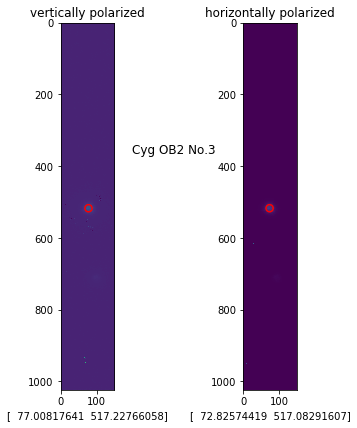

In [148]:
from photutils import CircularAperture
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
import pandas as pd

centroid_left = (620,720) #o-ray
centroid_right = (880,720) #e-ray
box_size=150
fwhm=20
constant=1000

o_strip, e_strip, new_centroids = get_strip(pol,centroid_left,centroid_right, show_image=True)

## Point-source detection 

quicker alternative; slow and not optimized

### o-image (right)

In [153]:
from photutils import CircularAperture
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
import pandas as pd
from scipy.optimize import curve_fit

def gauss(x, *params):
    A, mu, sigma, eps= params
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + eps

def get_sources(image, fwhm, constant):
    daofind = DAOStarFinder(fwhm=fwhm, threshold=10*np.std(image))
    sources = daofind(image-constant)
    df = sources.to_pandas()
    return df

def check_psf(pol,centroid_left,skip_every,box_size=150,constant=1000,fwhm=20,show_crop_image=False):
    centers=[]
    fig,ax=plt.subplots(1,1)
    for idx,i in tqdm(enumerate(pol[::skip_every])):
        #print(pf.open(i)[0].header['OBJECT'])
        img=pf.open(i)[0].data
        #
        o_strip, e_strip, new_centroids = get_strip(pol,centroid_left,centroid_right, show_image=False)
        
        try:
            img_crop = get_crop(o_strip, new_centroids[0], box_size)
            if show_crop_image==True:
                vmin,vmax=np.median(img_crop), 10*np.median(img_crop)
                plt.imshow(img_crop,vmin=vmin,vmax=vmax)
                #apertures = CircularAperture(new_centroid, r=fwhm/2)
                #apertures.plot(color='red', lw=1.5)
                plt.show()
            psf_swath = []
            swath = np.arange(int(new_centroids[0][0])-15,int(new_centroids[0][0])+15,1)
            for j in swath:
                line=img_crop[j]/np.max(img_crop[j])
                psf_swath.append(line)
        except:
            pass
        #if True: #show_psf == True:
        mean_psf_swath = np.mean(psf_swath,axis=0)
        ax.plot(mean_psf_swath, 'o',label=idx)
        centers.append(new_centroids[0])
        
    #if True: #show_psf == True:
    #mean_psf= np.mean(mean_psf_swath,axis=0)
    ax.plot(mean_psf_swath, 'k-',label='mean')
    ax.set_title('PSF of {}'.format(pf.open(pol[0])[0].header['OBJECT']))
    plt.legend()
    plt.show()
    return mean_psf_swath, centers

def fit_psf(pol,mean_psf, centers):
    ydata = np.copy(mean_psf)#np.mean(mean_psf,axis=0))
    xdata = np.array(range(len(ydata)))
    #estimate mean and standard deviation
    mean = np.mean(centers,axis=0)[0]
    sigma = np.std(ydata)
    #fitting
    eps =0.1
    popt, pcov = curve_fit(gauss, xdata, ydata, p0 = [1, mean, sigma, eps])
    FWHM=2*np.sqrt(2*np.log(2))*popt[2]
    #plot psf
    plt.plot(xdata,gauss(xdata, *popt), label='Gaussian fit')
    plt.plot(xdata,ydata,'ok', label='data (mean)')
    plt.title('PSF of {}'.format(pf.open(pol[0])[0].header['OBJECT']))
    plt.xlabel('FWHM={0:.2f} pix, $\sigma$={1:.2f}'.format(FWHM,popt[2]))
    plt.legend()
    plt.show()
    print('A: {}\nmu: {}\nsigma= {}\neps: {}'.format(*popt)) #popt[0],popt[1], popt[2], popt[3]
    return popt, pcov

4it [00:02,  1.41it/s]


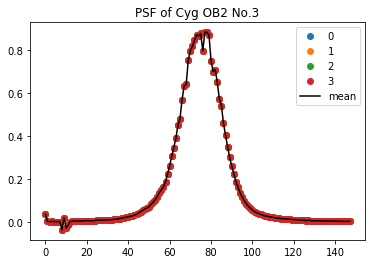

In [154]:
centroid_left = (620,720) #o-ray
centroid_right = (880,720) #e-ray

box_size=150
mean_psf, centers=check_psf(pol,centroid_left,skip_every=5,constant=1000,show_crop_image=False)

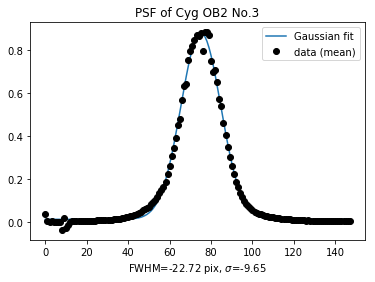

A: 0.867079845056
mu: 75.0654953345
sigma= -9.64997395327
eps: 0.0138225552945


In [155]:
popt, pcov=fit_psf(pol, mean_psf, centers)

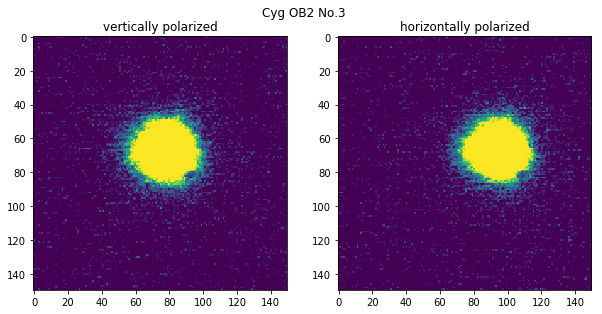

In [133]:
centroid_left = (640,720) #o-ray
centroid_right = (880,720) #e-ray
box_size = 150

image = pf.open(pol[0])[0].data
o = get_crop(image, centroid_left, box_size)
e = get_crop(image, centroid_right, box_size)

#mean, median, std = sigma_clipped_stats(test_image, sigma=3.0, iters=5)
vmin,vmax= np.median(o), 10*np.median(o)

fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(o-np.median(o), vmin=vmin, vmax=vmax)
axs[0].set_title('vertically polarized')
axs[1].imshow(e-np.median(e), vmin=vmin, vmax=vmax)
axs[1].set_title('horizontally polarized')
fig.suptitle(pf.open(pol[0])[0].header['OBJECT'])
fig.subplots_adjust(top=1.4)

### e-image (right)

4it [00:01,  2.70it/s]


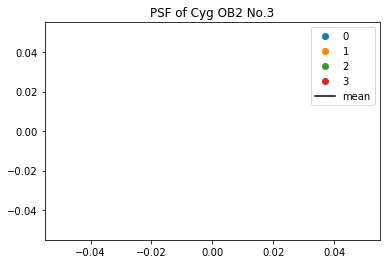

In [100]:
centroid_left = (620,720) #o-ray
centroid_right = (880,720) #e-ray

box_size=150
mean_psf, centers=check_psf(pol,centroid_right,skip_every=5,constant=100,show_image=False)

## Distortion correction

## Stacking

In [35]:
'''
Method 1: slicing at proper WP position
'''
for idx, i in enumerate(range(len(pol))[::4]):
    #print(pf.open(pol[i])[0].header['I_DTHPOS'])
    #print(pf.open(pol[i+1])[0].header['I_DTHPOS'])
    #print(pf.open(pol[i+2])[0].header['I_DTHPOS'])
    print(pf.open(pol[i+3])[0].header['I_DTHPOS'], idx)

('1 : WP67.5', 0)
('2 : WP67.5', 1)
('3 : WP67.5', 2)
('4 : WP67.5', 3)
('5 : WP67.5', 4)


In [39]:
'''
Method: checking WP position from header
'''
for idx, i in enumerate(pol):
    wp_pos=pf.open(i)[0].header['I_DTHPOS'].split(':')[1].strip()
    if wp_pos == 'WP0':
        print(wp_pos)
    elif wp_pos == 'WP45':
        print(wp_pos)
    elif wp_pos == 'WP22.5':
        print(wp_pos)
    else: # wp_pos == 'WP67.5':
        print(wp_pos)

WP0
WP45
WP22.5
WP67.5
WP0
WP45
WP22.5
WP67.5
WP0
WP45
WP22.5
WP67.5
WP0
WP45
WP22.5
WP67.5
WP0
WP45
WP22.5
WP67.5


In [50]:
def get_crop_oe(pol,centroid_left,centroid_right,box_size=150,constant=1000,fwhm=20):
    '''
    since images are dithered, raw images should be cropped
    '''
    centers_left=[]
    centers_right=[]
    img_crop_left=[]
    img_crop_right=[]
    fig,ax=plt.subplots(1,1)
    for idx,i in tqdm(enumerate(pol)):
        #print(pf.open(i)[0].header['OBJECT'])
        img=pf.open(i)[0].data
        ###o-ray (left)
        strip1 = np.copy(img[:,int(centroid_left[0]-(box_size/2)):int(centroid_left[0]+(box_size/2))])
        df1=get_sources(strip1, fwhm, constant)
        new_centroid1=df1.sort_values(by='flux',ascending=False).head(1)[['xcentroid','ycentroid']].values.flatten()
        centers_left.append(new_centroid1)
        ###o-ray (left)
        strip2 = np.copy(img[:,int(centroid_right[0]-(box_size/2)):int(centroid_right[0]+(box_size/2))])
        df2=get_sources(strip2, fwhm, constant)
        new_centroid2=df2.sort_values(by='flux',ascending=False).head(1)[['xcentroid','ycentroid']].values.flatten()
        centers_right.append(new_centroid2)
        try:
            #o-img
            img_crop1 = get_crop(strip1, new_centroid1, box_size)
            img_crop_left.append(img_crop1)
            #e-img
            img_crop2 = get_crop(strip2, new_centroid2, box_size)
            img_crop_right.append(img_crop2)
            vmin,vmax= np.median(o), 10*np.median(o)

            fig, axs = plt.subplots(1,2)
            axs[0].imshow(img_crop1-np.median(img_crop1), vmin=vmin, vmax=vmax)
            axs[0].set_title('vertically polarized')
            axs[1].imshow(img_crop2-np.median(img_crop2), vmin=vmin, vmax=vmax)
            axs[1].set_title('horizontally polarized')
            fig.suptitle(pf.open(pol[0])[0].header['OBJECT'])
            plt.show()
        except:
            pass
    return img_crop1, img_crop2

0it [00:00, ?it/s]

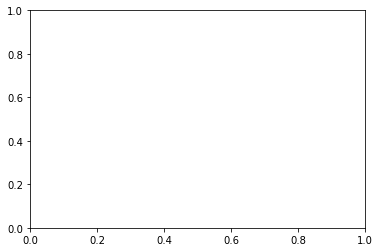

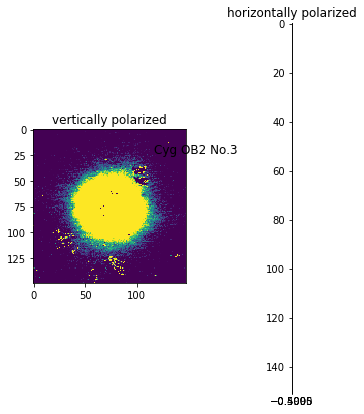

1it [00:01,  1.14s/it]

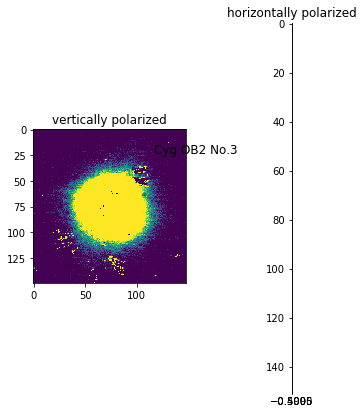

2it [00:02,  1.19s/it]

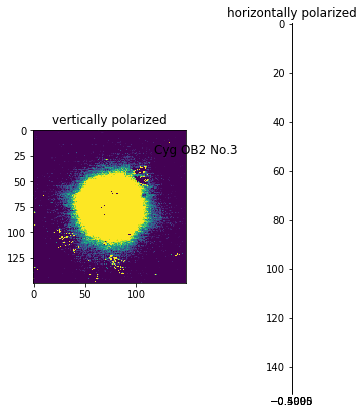

3it [00:03,  1.22s/it]

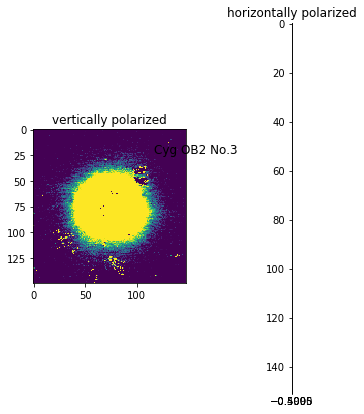

4it [00:04,  1.21s/it]

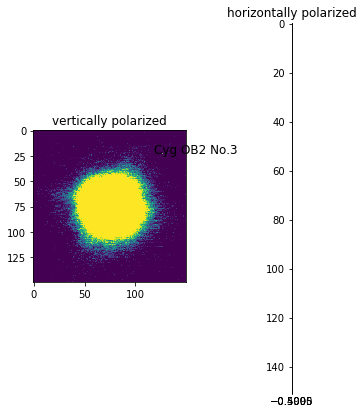

5it [00:06,  1.20s/it]

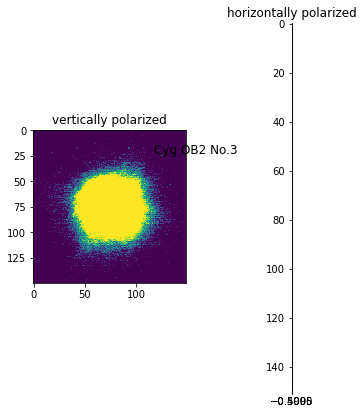

6it [00:07,  1.17s/it]

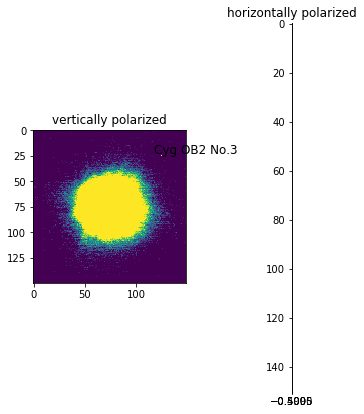

7it [00:08,  1.12s/it]

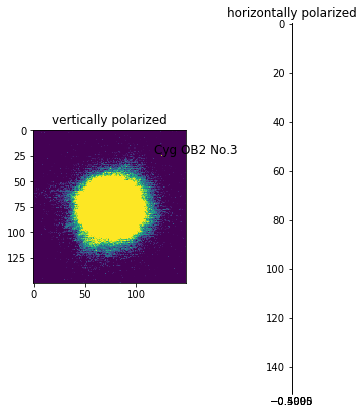

8it [00:09,  1.09s/it]

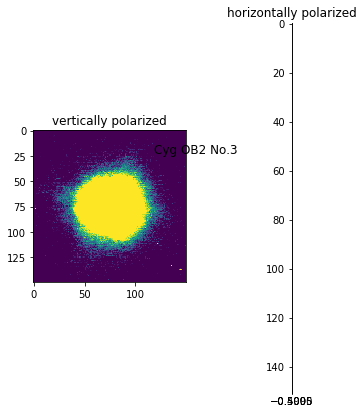

9it [00:10,  1.07s/it]

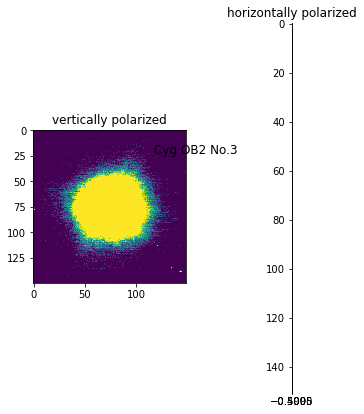

10it [00:11,  1.05s/it]

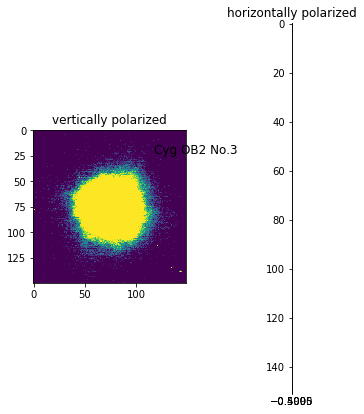

11it [00:12,  1.13s/it]

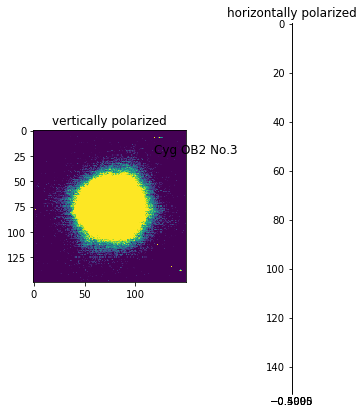

13it [00:14,  1.01s/it]

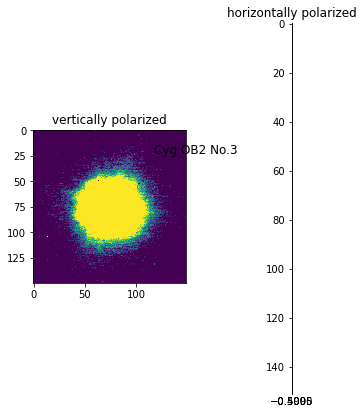

14it [00:15,  1.09s/it]

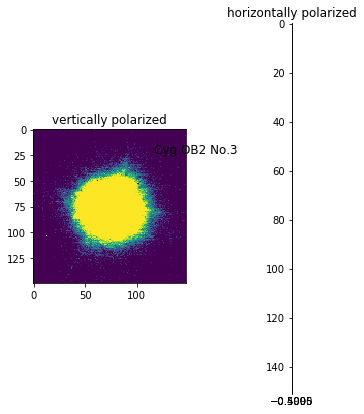

15it [00:16,  1.10s/it]

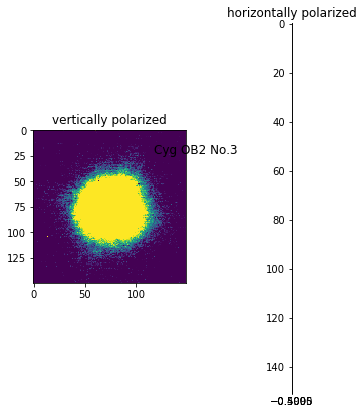

16it [00:18,  1.12s/it]

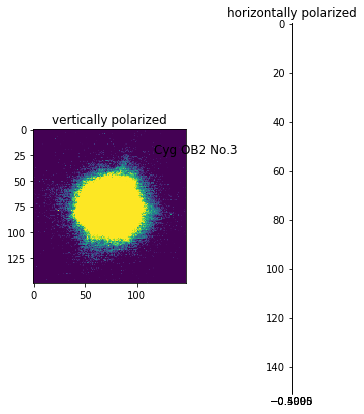

17it [00:19,  1.12s/it]

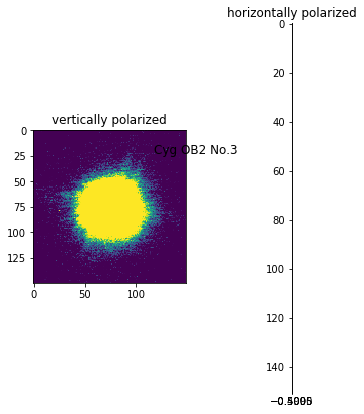

18it [00:20,  1.16s/it]

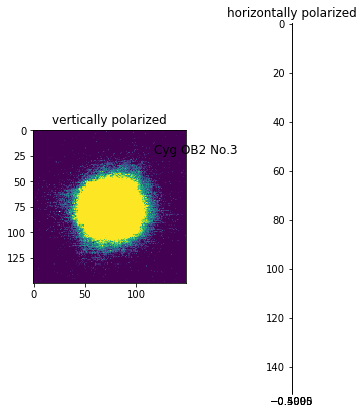

19it [00:21,  1.14s/it]

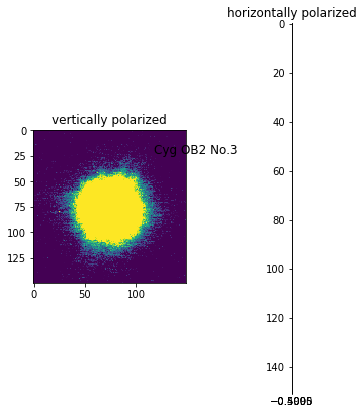

20it [00:22,  1.10s/it]


In [52]:
centroid_left = (620,720) #o-ray
centroid_right = (900,720) #e-ray

o_crop, e_crop=get_crop_oe(pol,centroid_left,centroid_right)

In [ ]:
def get_median_method1():
    for idx, i in enumerate(range(len(img_crop_left))[::4]):
        #WP=0
        img_crop_left[i]
        #WP=45
        img_crop_left[i+1]
        #WP=22.5
        img_crop_left[i+2]
        #WP=67.5
        img_crop_left[i+3]
    for idx, i in enumerate(range(len(img_crop_right))[::4]):
        #WP=0
        img_crop_right[i]
        #WP=45
        img_crop_right[i+1]
        #WP=22.5
        img_crop_right[i+2]
        #WP=67.5
        img_crop_right[i+3]

In [ ]:
def get_median(file_list, n_slices, show_image=None, save_image=None):
    '''
    stack n or all object images and returns stacked image
    '''
    obj_filenames = []
    
    for i in file_list:
        z = pf.open(i)
        hdr = z[0].header
        if hdr['OBJECT']  == 'HAT-P-44':
            obj_filenames.append(i)

    # take 1457/n_slices = 30 images
    print('Stacking {0} images'.format(len(obj_filenames[::n_slices])))

    objs = np.array([pf.getdata("%s" % n) for n in obj_filenames[::n_slices]])

    print('Shape of array to be stacked: {0}'.format(objs.shape))
    objs_stacked = np.median(objs, axis=0)
    
    fig = plt.figure(figsize=(10,10))
    
    if show_image is None: #default
        norm = ImageNormalize(stretch=SqrtStretch())
        plt.imshow(objs_stacked,cmap='Greys', origin='lower', norm=norm)
        plt.show()
    
    if save_image is True: #False by default
        fname='obj_med'+n_slices+'.fits'
        print('Saving stacked image as {}'.format(fname))
        pyfits.writeto(fname, objs_stacked, header=hdr)
    
    return objs_stacked

## Aperture polarimetry

In [ ]:
from photutils import CircularAperture
from photutils import aperture_photometry


def get_phot(image, centroid, r=10):
    fwhm = 8.0
    
    apertures = CircularAperture(centroid, r)
    phot_table = aperture_photometry(image, apertures)
    
    #xcenter = phot_table['xcenter']
    #ycenter = phot_table['ycenter']
    #centroid = (xcenter, ycenter)
    aperture_sum = float(phot_table['aperture_sum'])
    
    return aperture_sum #,centroid

In [ ]:
aperture_sum = get_phot(test_image_crop, centroid)
aperture_sum